In [ ]:
!pip install trulens==0.13

In [ ]:
import os
os.chdir("CemAttributionDemo")

In [ ]:
import torch
import os
# from CUB.config import BASE_DIR, N_CLASSES, N_ATTRIBUTES
# from CUB.dataset import load_data
# from saliency.saliency_zoo import mfaba_smooth,isa
from torchvision.transforms import Normalize
from torchvision import transforms
import numpy as np

In [3]:
mean = [0.5, 0.5, 0.5]
std = [2, 2, 2]
norm_layer = Normalize(mean = mean, std = std)
inverse_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x * torch.tensor(std).cuda().view(3, 1, 1)),
    transforms.Lambda(lambda x: x + torch.tensor(mean).cuda().view(3, 1, 1))
])

In [4]:
# data_dir = os.path.join(BASE_DIR,"CUB_processed/class_attr_data_10", 'test' + '.pkl')
# loader = load_data([data_dir], True, False, 16, image_dir="images",
#                     n_class_attr=112)

In [5]:
import cem.models.cem as models_cem
from cem.train import utils
import torch
cem_model_state_dict = torch.load("CEM_fold_1.pt")
from torchvision.models import resnet18, resnet34, resnet50, densenet121
model_cls = models_cem.ConceptEmbeddingModel
extra_params = {
    "emb_size": 16,
    "shared_prob_gen": True,
    "intervention_policy": None,
    "training_intervention_prob": 0.25,
    "embedding_activation": "leakyrelu",
    "c2y_model": None,
    "c2y_layers": [],
}
c_extractor_arch = resnet34
cem_model = model_cls(
        n_concepts=112,
        n_tasks=200,
        weight_loss=(
            None
        ),
        task_class_weights=(
            None
        ),
        concept_loss_weight=5,
        task_loss_weight=1.0,
        learning_rate=0.01,
        weight_decay=0.000004,
        c_extractor_arch=utils.wrap_pretrained_model(c_extractor_arch),
        optimizer="sgd",
        top_k_accuracy="null",
        output_latent=False,
        output_interventions=False,
        **extra_params,
    )

c:\Users\Zhang\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Zhang\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# for data in loader:
#     inputs, labels, attr_labels = data
#     attr_labels = torch.stack(attr_labels).t() 
#     inputs, labels, attr_labels = inputs.cuda(), labels.cuda(), attr_labels.cuda()
#     inputs = inverse_normalize(inputs)
#     break

In [7]:
# torch.save((inputs, labels, attr_labels),"inputs_labels_attr_labels.pt")
inputs, labels, attr_labels = torch.load("inputs_labels_attr_labels.pt")

In [8]:
del cem_model_state_dict["loss_concept.weight"]
cem_model.load_state_dict(cem_model_state_dict)

<All keys matched successfully>

In [9]:
cem_model = cem_model.cuda().eval()

In [10]:
from tqdm.notebook import tqdm

In [11]:
class NewCEMModel(torch.nn.Module):
    def __init__(self, model):
        super(NewCEMModel, self).__init__()
        self.model = model
        self.norm_layer = norm_layer
        self.norm_layer.requires_grad_(False)
    def forward(self, x, return_idx=None):
        x = self.norm_layer(x)
        output = self.model.pre_concept_model(x)
        concept_p = []
        
        for i in range(len(self.model.concept_context_generators)):
            g = self.model.concept_context_generators[i]
            p = self.model.concept_prob_generators[0]
            g_output = g(output)
            pos_emb = g_output[:, :self.model.emb_size]
            neg_emb = g_output[:, self.model.emb_size:]
            p_output = p(g_output)
            p_output = torch.sigmoid(p_output)
            if return_idx is not None:
                if i == return_idx:
                    return p_output
            concept_p.append(pos_emb * p_output + neg_emb * (1 - p_output))
        
        concept_p = torch.cat(concept_p, dim=1)
        return self.model.c2y_model(concept_p)


In [12]:
new_cem_model = NewCEMModel(cem_model).cuda().eval()

In [13]:
used_112 = [1, 4, 6, 7, 10, 14, 15, 20, 21, 23, 25, 29, 30, 35, 36, 38, 40, 44, 45, 50, 51, 53, 54, 56, 57, 59, 63, 64, 69, 70, 72, 75, 80, 84, 90, 91, \
93, 99, 101, 106, 110, 111, 116, 117, 119, 125, 126, 131, 132, 134, 145, 149, 151, 152, 153, 157, 158, 163, 164, 168, 172, 178, 179, 181, \
183, 187, 188, 193, 194, 196, 198, 202, 203, 208, 209, 211, 212, 213, 218, 220, 221, 225, 235, 236, 238, 239, 240, 242, 243, 244, 249, 253, \
254, 259, 260, 262, 268, 274, 277, 283, 289, 292, 293, 294, 298, 299, 304, 305, 308, 309, 310, 311]

In [14]:
# all_attributes = open(r"\CUB_200_2011\attributes\attributes.txt").readlines()
# all_attributes = [x.strip().split(",") for x in all_attributes]
# # all_attributes
# used_attributes = []
# for i in range(len(all_attributes)):
#     if i in used_112:
#         used_attributes.append(all_attributes[i][0])
# with open("used_attributes.txt", "w") as f:
#     for i in range(len(used_attributes)):
#         f.write(used_attributes[i] + "\n")
all_used_attributes = open("used_attributes.txt").readlines()
all_used_attributes = [x.strip() for x in all_used_attributes]
print(all_used_attributes)

['2 has_bill_shape::dagger', '5 has_bill_shape::hooked_seabird', '7 has_bill_shape::all-purpose', '8 has_bill_shape::cone', '11 has_wing_color::brown', '15 has_wing_color::grey', '16 has_wing_color::yellow', '21 has_wing_color::black', '22 has_wing_color::white', '24 has_wing_color::buff', '26 has_upperparts_color::brown', '30 has_upperparts_color::grey', '31 has_upperparts_color::yellow', '36 has_upperparts_color::black', '37 has_upperparts_color::white', '39 has_upperparts_color::buff', '41 has_underparts_color::brown', '45 has_underparts_color::grey', '46 has_underparts_color::yellow', '51 has_underparts_color::black', '52 has_underparts_color::white', '54 has_underparts_color::buff', '55 has_breast_pattern::solid', '57 has_breast_pattern::striped', '58 has_breast_pattern::multi-colored', '60 has_back_color::brown', '64 has_back_color::grey', '65 has_back_color::yellow', '70 has_back_color::black', '71 has_back_color::white', '73 has_back_color::buff', '76 has_tail_shape::notched_ta

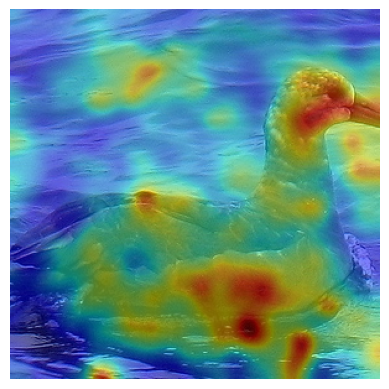

In [15]:
# attr_indexs = [2, 6, 11, 17, 23, 71, 76, 78, 81, 97]
from plot import plot
# from plot import plot_save
IDX = 1


# for attr_index in attr_indexs:
    # for data in tqdm(loader):
    #     inputs, labels, attr_labels = data
    #     attr_labels = torch.stack(attr_labels).t() 
    #     inputs, labels, attr_labels = inputs.cuda(), labels.cuda(), attr_labels.cuda()
    #     inputs = inverse_normalize(inputs)
    #     break
attr_index = 0
attribution = torch.zeros_like(inputs)
conf = None
for i in range(10):
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    outputs = new_cem_model(inputs,return_idx=attr_index)
    # print(outputs[IDX:IDX+1])
    if conf is None:
        conf = outputs[IDX:IDX+1].squeeze().item()
    loss = new_cem_model.model.loss_concept(outputs, attr_labels[:,attr_index:attr_index+1].float())
    loss.backward()
    grad = inputs.grad.clone()
    inputs.grad.zero_()
    last_inputs = inputs.detach().clone()
    inputs = inputs + grad.sign() * 0.001
    attribution += (inputs - last_inputs) * grad
    
attribution = attribution[IDX:IDX+1] / 10
plot(attribution.cpu().detach().numpy(),inputs[IDX:IDX+1].cpu().detach())
    # plot_save(attribution.cpu().detach().numpy(),inputs[IDX:IDX+1].cpu().detach(),f"concept_attr/{attr_index}_{conf}.png")
